<a href="https://colab.research.google.com/github/jkranyak/project_3/blob/GAN_Branch/project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install tensorflow
!pip install isic-cli
!pip install isic-cli
!pip install kaggle
!pip install imblearn

In [ ]:
! isic user login

visit the following url in a browser:
https://api.isic-archive.com/oauth/authorize?response_type=code&client_id=RpCzc4hFjv5gOJdM2DM2nBdokOviOh5ne63Tpn7Q&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=nHEnl6TM0TFt2mDL0meoaxeqjxZeXt&code_challenge=zqVvw9P1hvPUVYT5UUDxG9NJrwS2Ct3YEutJEW5E9-g&code_challenge_method=S256
enter the code shown in your browser: W4vmWFPIAacpcYtd6c4pCKeNf7yiNc
Success!


In [ ]:
!isic collection list

┏━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ ID  ┃ Name                                          ┃ Public ┃ Pinned ┃ Locked ┃ DOI             ┃
┡━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ 249 │ BCN20000                                      │ True   │ False  │ False  │ None            │
│ 61  │ Challenge 2016: Test                          │ True   │ True   │ True   │ None            │
│ 74  │ Challenge 2016: Training                      │ True   │ True   │ True   │ None            │
│ 69  │ Challenge 2017: Test                          │ True   │ True   │ True   │ None            │
│ 60  │ Challenge 2017: Training                      │ True   │ True   │ True   │ None            │
│ 71  │ Challenge 2017: Validation                    │ True   │ True   │ True   │ None            │
│ 64  │ Challenge 2018: Task 1-2: Test                │ True   │ True   │ True   │ None    

Step 2: Query the Dataset
Endpoints: Use the API endpoints to query the dataset. Common operations include listing available images, retrieving image metadata, and downloading images.
Filtering: Utilize query parameters to filter the dataset based on your criteria, such as diagnosis, image type, or other metadata.

In [ ]:
import requests
import os
import pandas as pd
import tensorflow as tf
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import resample


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from imblearn.over_sampling import SMOTE
from pathlib import Path
from google.colab import drive
from PIL import Image

In [ ]:
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
image_dir = "/content/drive/My Drive/Generated_Images"
if not os.path.exists(image_dir):
    os.makedirs(image_dir)


Comment out if already running

In [ ]:
# Specify the current path of kaggle.json file
current_path = '/content/kaggle.json'

# Desired path where the Kaggle API expects the kaggle.json file
desired_path = '/root/.kaggle/kaggle.json'

if os.path.exists(current_path):
    os.makedirs(os.path.dirname(desired_path), exist_ok=True)
    os.rename(current_path, desired_path)

    # Set the file's permissions to avoid a permissions error
    os.chmod(desired_path, 0o600)
else:
    print(f"Error: '{current_path}' does not exist. Please upload the file.")



find the data set on kaggle

Comment out if running and already have downloaded images

In [ ]:
!kaggle datasets download -d andrewmvd/isic-2019


100% 9.09G/9.10G [01:11<00:00, 140MB/s]
100% 9.10G/9.10G [01:11<00:00, 136MB/s]


In [ ]:
!unzip -q isic-2019.zip


Step 1: Data Preparation and Preprocessing
DICOM Images





Load the metadata

and

Explore the Metadata CSV: Load the metadata.csv files for training, test, and validation sets to understand the structure and types of data available. This step is crucial for preprocessing and feature selection.

In [44]:
# Load the metadata
metadata = pd.read_csv('/content/ISIC_2019_Training_Metadata.csv')

# Display the first few rows of each DataFrame
metadata.head()


,image,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,55.0,anterior torso,NaN,female
1,ISIC_0000001,30.0,anterior torso,NaN,female
2,ISIC_0000002,60.0,upper extremity,NaN,female
3,ISIC_0000003,30.0,upper extremity,NaN,male
4,ISIC_0000004,80.0,posterior torso,NaN,male


In [45]:
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')
ground_truth

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [46]:
# Load the CSV files
ground_truth = pd.read_csv('/content/ISIC_2019_Training_GroundTruth.csv')
metadata = pd.read_csv('/content/ISIC_2019_Training_Metadata.csv')

image_dir = Path('/content/ISIC_2019_Training_Images')
ground_truth['image_path'] = ground_truth['image'].apply(lambda x: image_dir / f"{x}.jpg")

# Merge the ground_truth with metadata if necessary
full_metadata = pd.merge(ground_truth, metadata, on='image', how='left')  # Adjust 'on' parameter as needed
full_metadata

,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC,UNK,image_path,age_approx,anatom_site_general,lesion_id,sex
0,ISIC_0000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,55.0,anterior torso,NaN,female
1,ISIC_0000001,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,30.0,anterior torso,NaN,female
2,ISIC_0000002,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,60.0,upper extremity,NaN,female
3,ISIC_0000003,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,30.0,upper extremity,NaN,male
4,ISIC_0000004,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_000000...,80.0,posterior torso,NaN,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25326,ISIC_0073247,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,85.0,head/neck,BCN_0003925,female
25327,ISIC_0073248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,65.0,anterior torso,BCN_0001819,male
25328,ISIC_0073249,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007324...,70.0,lower extremity,BCN_0001085,male
25329,ISIC_0073251,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/content/ISIC_2019_Training_Images/ISIC_007325...,55.0,palms/soles,BCN_0002083,female


In [47]:
# Display the image paths for the first few entries
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Images/ISIC_000000...
1    /content/ISIC_2019_Training_Images/ISIC_000000...
2    /content/ISIC_2019_Training_Images/ISIC_000000...
3    /content/ISIC_2019_Training_Images/ISIC_000000...
4    /content/ISIC_2019_Training_Images/ISIC_000000...
Name: image_path, dtype: object


In [48]:
# Correct the base path in 'image_path' column
correct_base_path = "/content/ISIC_2019_Training_Input/ISIC_2019_Training_Input"

full_metadata['image_path'] = full_metadata['image'].apply(lambda x: f"{correct_base_path}/{x}.jpg")

# Verify the correction by printing the first few entries again
print(full_metadata['image_path'].head())


0    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
1    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
2    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
3    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
4    /content/ISIC_2019_Training_Input/ISIC_2019_Tr...
Name: image_path, dtype: object


In [49]:
full_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25331 entries, 0 to 25330
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                25331 non-null  object 
 1   MEL                  25331 non-null  float64
 2   NV                   25331 non-null  float64
 3   BCC                  25331 non-null  float64
 4   AK                   25331 non-null  float64
 5   BKL                  25331 non-null  float64
 6   DF                   25331 non-null  float64
 7   VASC                 25331 non-null  float64
 8   SCC                  25331 non-null  float64
 9   UNK                  25331 non-null  float64
 10  image_path           25331 non-null  object 
 11  age_approx           24894 non-null  float64
 12  anatom_site_general  22700 non-null  object 
 13  lesion_id            23247 non-null  object 
 14  sex                  24947 non-null  object 
dtypes: float64(10), object(5)
memory usa

In [50]:
# Fill missing values for 'age_approx' with its median
full_metadata['age_approx'].fillna(full_metadata['age_approx'].median(), inplace=True)

# For categorical data, fill missing values with 'unknown'
full_metadata['anatom_site_general'].fillna('unknown', inplace=True)
full_metadata['sex'].fillna('unknown', inplace=True)


In [51]:
full_metadata = pd.get_dummies(full_metadata, columns=['anatom_site_general', 'sex'])


In [58]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, Multiply, BatchNormalization, Activation, Embedding, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU, UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

# Build the generator model
def build_generator(latent_dim, num_classes):
    model = Sequential()
    model.add(Dense(128 * 56 * 56, activation="relu", input_dim=latent_dim))  # Adjust size here
    model.add(Reshape((56, 56, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(3, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(latent_dim,))
    label = Input(shape=(1,), dtype='int32')
    label_embedding = Flatten()(Embedding(num_classes, latent_dim)(label))
    model_input = Multiply()([noise, label_embedding])
    img = model(model_input)

    return Model([noise, label], img)

generator = build_generator(latent_dim, num_classes)
generator.summary()

# Build the discriminator model
def build_discriminator(img_shape):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    img = Input(shape=img_shape)
    validity = model(img)
    return Model(img, validity)



Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 100)               1000      ['input_7[0][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 flatten_2 (Flatten)         (None, 100)                  0         ['embedding_1[0][0]']         
                                                                                            

In [59]:
# Training the GAN
def train(generator, discriminator, combined, epochs, batch_size, latent_dim, num_classes, class_proportions):
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        for _ in range(batch_size):
            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and categorical labels
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            sampled_labels = np.random.choice(range(num_classes), batch_size, p=class_proportions)

            # Generate a batch of new images
            gen_imgs = generator.predict([noise, sampled_labels])

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train the generator (wants discriminator to mistake images as real)
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            sampled_labels = np.random.choice(range(num_classes), batch_size, p=class_proportions)
            g_loss = combined.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print(f"Epoch: {epoch}, D loss: {d_loss}, G loss: {g_loss}")

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                save_images(epoch, generator, sampled_labels)


In [60]:
def save_images(epoch, generator, labels, n_classes=10):
    noise = np.random.normal(0, 1, (n_classes * 10, 100))
    sampled_labels = np.array([i for i in range(n_classes) for _ in range(10)])
    gen_imgs = generator.predict([noise, sampled_labels])

    # Rescale images from [-1,1] to [0,1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(n_classes, 10, figsize=(10, n_classes))
    cnt = 0
    for i in range(n_classes):
        for j in range(10):
            axs[i, j].imshow(gen_imgs[cnt, :, :, :])
            axs[i, j].axis('off')
            cnt += 1

    image_dir = "/content/myimages/training"  # Ensure this directory exists
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

    plt.savefig(f"{image_dir}/gan_generated_epoch_{epoch}.png")
    plt.close()

# Make sure to define `save_interval` if it's used in the loop
save_interval = 10  # Save images every 10 epochs, adjust as necessary

# This code snippet implies you will continue training or adjust parameters based on the output.


In [61]:
# Assuming latent dimension and number of classes
latent_dim = 100
num_classes = 10
img_shape = (224, 224, 3)

# Instantiate the generator and discriminator
generator = build_generator(latent_dim, num_classes)
discriminator = build_discriminator(img_shape)

# Compile the discriminator
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(0.0002, 0.5),
                      metrics=['accuracy'])

# Combined model (generator and discriminator)
z = Input(shape=(latent_dim,))
label = Input(shape=(1,))
img = generator([z, label])
discriminator.trainable = False
valid = discriminator(img)
combined = Model([z, label], valid)
combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
# Make sure models are created
print("Generator and Discriminator models are built and compiled.")


Generator and Discriminator models are built and compiled.


4/4 [==============================] - 2s 322ms/step


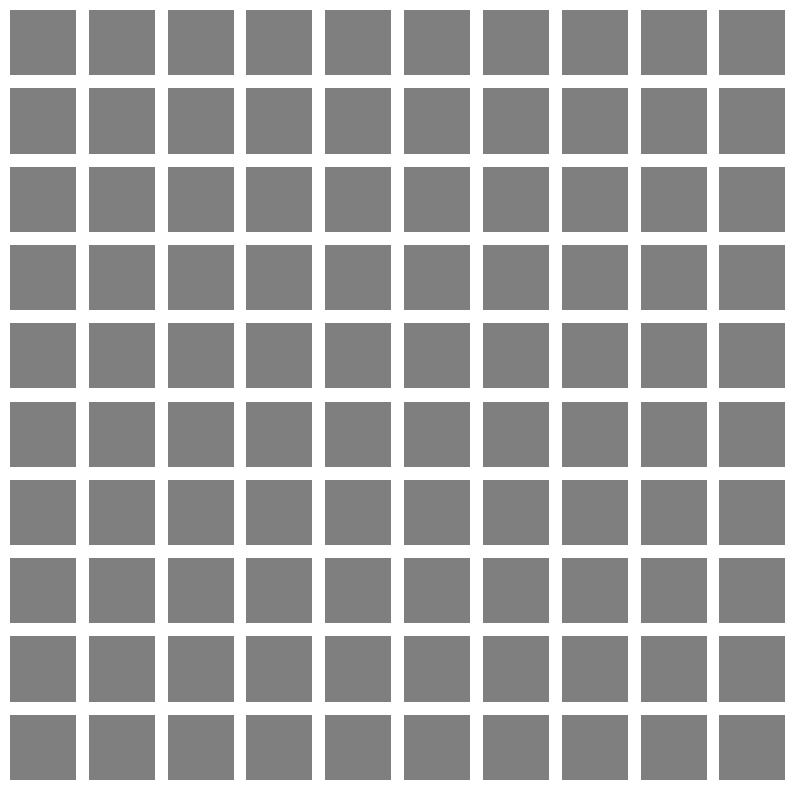

In [62]:
import matplotlib.pyplot as plt

def generate_and_save_images(model, epoch, test_input, test_labels, n_classes=10):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model.predict([test_input, test_labels])

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow((predictions[i] * 127.5 + 127.5).astype(np.uint8))
        plt.axis('off')

    plt.savefig('/content/myimages/training/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

# Generate test noise and labels
test_noise = np.random.normal(0, 1, (100, latent_dim))
test_labels = np.array([num for num in range(num_classes) for _ in range(10)])

# Generate and save images
generate_and_save_images(generator, 0, test_noise, test_labels)


In [64]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from scipy.linalg import sqrtm
from skimage.transform import resize
import numpy as np

def calculate_fid(model, real_images, generated_images):
    # Resize images
    real_images = np.array([resize(image, (299, 299, 3)) for image in real_images])
    generated_images = np.array([resize(image, (299, 299, 3)) for image in generated_images])

    # Preprocess images
    real_images = preprocess_input(real_images)
    generated_images = preprocess_input(generated_images)

    # Actvations for the real and generated images
    act1 = model.predict(real_images)
    act2 = model.predict(generated_images)

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Load Inception model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))


87910968/87910968 [==============================] - 0s 0us/step


In [65]:
def evaluate_generator(generator, num_images=100):
    noise = np.random.normal(0, 1, (num_images, 100))
    sampled_labels = np.array([i % 10 for i in range(num_images)])  # Adjust based on your number of classes
    gen_imgs = generator.predict([noise, sampled_labels])

    # Generate real images or load them appropriately
    real_images = load_real_images(num_images)  # This needs to be implemented

    # Calculate FID
    fid_value = calculate_fid(model, real_images, gen_imgs)
    print(f'FID score: {fid_value}')

# Example call after training
evaluate_generator(generator)


4/4 [==============================] - 1s 317ms/step


NameError: name 'load_real_images' is not defined